In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB 
import xgboost as xgb

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.utils import to_categorical

Using TensorFlow backend.


# Done to check 1.0 notebook

In [2]:
traindf = pd.read_csv("train.csv")
testdf = pd.read_csv("test.csv")
subdf = pd.read_csv("sample_submission.csv")

In [3]:
traindf.head()

,ID,Person A,Person B,Years of Knowing,Interaction Duration,Interaction Type,Moon Phase During Interaction,Friends
0,1,Alika,Alfie,3.876560,13.035115,Class,Waning_Gibbous,1
1,2,Pennie,Lolita,2.836218,5.811429,At Work,Waxing_Cresent,0
2,3,Crissy,Carree,3.006119,4.882863,Over a Meal,New_Moon,0
3,4,Eyde,Karleen,2.960067,9.274924,Social_Media,Waxing_Gibbous,0
4,5,Chrysa,Ludovika,7.640688,8.843167,Class,First_Quarter,1


In [4]:
aggTrain = traindf.groupby(['Person A', 'Person B'])['Interaction Type'].count().reset_index()
aggTrain = aggTrain.rename({"Interaction Type" : "Interaction Count"}, axis=1)
aggTrain.head()

,Person A,Person B,Interaction Count
0,Addia,Agneta,3
1,Addia,Alejandra,7
2,Addia,Alfie,9
3,Addia,Alicea,9
4,Addia,Alicia,9


In [5]:
traindf = pd.merge(traindf, aggTrain, on=['Person A', 'Person B'], how='left')
traindf.head()

,ID,Person A,Person B,Years of Knowing,Interaction Duration,Interaction Type,Moon Phase During Interaction,Friends,Interaction Count
0,1,Alika,Alfie,3.876560,13.035115,Class,Waning_Gibbous,1,8
1,2,Pennie,Lolita,2.836218,5.811429,At Work,Waxing_Cresent,0,5
2,3,Crissy,Carree,3.006119,4.882863,Over a Meal,New_Moon,0,6
3,4,Eyde,Karleen,2.960067,9.274924,Social_Media,Waxing_Gibbous,0,7
4,5,Chrysa,Ludovika,7.640688,8.843167,Class,First_Quarter,1,9


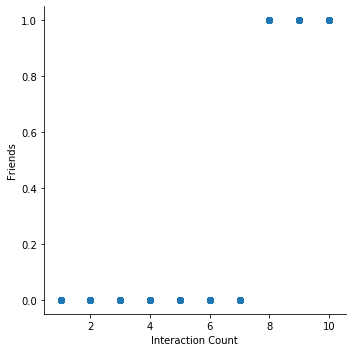

In [6]:
sns.lmplot("Interaction Count", "Friends", data=traindf, fit_reg=False)

In [7]:
ct=0
for i in range(len(traindf)):
    if(traindf["Person A"][i] == "Addia" and traindf["Person B"][i] == "Alejandra"):
        ct=ct+1
        print(traindf["Years of Knowing"][i], traindf["Interaction Duration"][i])
ct

3.4540605682545427 12.683241387293384
5.011774977267526 12.824876135733414
3.324446242178285 5.638068567470688
3.0149202306384604 5.4648915100812765
4.6641993529392884 4.749711220416327
1.570756578706891 8.091039205556825
2.7895499202474183 7.637868126579278


7

# Code

In [8]:
traindf = pd.read_csv("train.csv", usecols=['Years of Knowing', 'Interaction Duration', 'Friends'])
testdf = pd.read_csv("test.csv", usecols=['Years of Knowing', 'Interaction Duration'])
subdf = pd.read_csv("sample_submission.csv")

In [9]:
traindf.head()

,Years of Knowing,Interaction Duration,Friends
0,3.876560,13.035115,1
1,2.836218,5.811429,0
2,3.006119,4.882863,0
3,2.960067,9.274924,0
4,7.640688,8.843167,1


In [10]:
testdf.head()

,Years of Knowing,Interaction Duration
0,5.662542,14.863449
1,2.685942,3.002966
2,4.702476,13.453554
3,1.727021,3.780898
4,5.539269,10.626012


In [11]:
subdf.head()

,ID,Friends
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [12]:
traindf.isna().sum()

Years of Knowing        0
Interaction Duration    0
Friends                 0
dtype: int64

In [13]:
testdf.isna().sum()

Years of Knowing        0
Interaction Duration    0
dtype: int64

In [14]:
np.unique(np.array(traindf["Friends"]), return_counts=True)

(array([0, 1]), array([28125, 26572]))

Heat Map

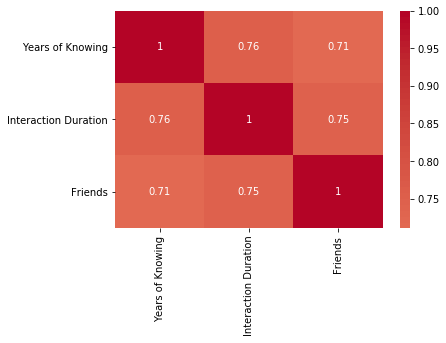

In [15]:
sns.heatmap(traindf.corr(),center=0, cmap='coolwarm', annot=True)

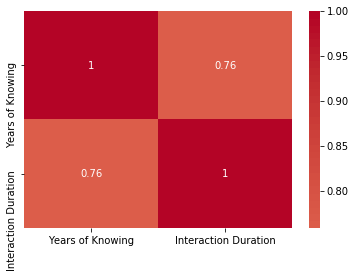

In [16]:
sns.heatmap(testdf.corr(),center=0, cmap='coolwarm', annot=True)

In [17]:
#traindf["Interaction Type"].unique()

In [18]:
#traindf["Moon Phase During Interaction"].unique()

In [19]:
def process(df):
    x = (df[["Years of Knowing", "Interaction Duration"]].values)#.reshape(-1, 1))
    x = StandardScaler().fit_transform(x)
    
    '''df1 = pd.get_dummies(df["Interaction Type"], drop_first=True)
    df2 = pd.get_dummies(df["Moon Phase During Interaction"], drop_first=True)
    df3 = pd.concat([df1, df2], axis=1)
    
    df = pd.concat([df, df3], axis=1)
    df = df.drop(["Interaction Type", "Moon Phase During Interaction"], axis=1)'''

    return x

In [20]:
x = process(traindf)
testX = process(testdf)
y = traindf.Friends.values

x.shape, testX.shape

((54697, 2), (54697, 2))

In [21]:
def baseliner(x, y, cv=3, metric='accuracy'):
    print("Baseliner Models\n")
    eval_dict = {}
    models = [LogisticRegression(), RandomForestClassifier(), GaussianNB(), SVC(gamma='auto'), xgb.XGBClassifier()]
    print("Model Name \t |   CV")
    print("------------------------")

    for index, model in enumerate(models, 0):
        model_name = str(model).split("(")[0]
        eval_dict[model_name] = {}

        results = cross_val_score(model, x, y, cv=cv, scoring=metric)
        eval_dict[model_name]['cv'] = results.mean()

        print("%s \t | %.4f \t" % (model_name[:12], eval_dict[model_name]['cv']))
        
baseliner(x, y)

Baseliner Models

Model Name 	 |   CV
------------------------
LogisticRegr 	 | 0.9157 	
RandomForest 	 | 0.9061 	
GaussianNB 	 | 0.9110 	
SVC 	 | 0.9170 	
XGBClassifie 	 | 0.9151 	


In [22]:
model = Sequential()
model.add(Dense(128, activation = 'relu', input_shape = x[0].shape))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x, to_categorical(y), epochs=20, validation_split=0.2)


Train on 43757 samples, validate on 10940 samples
Epoch 1/20
43757/43757 [==============================] - 3s 61us/step - loss: 0.1872 - accuracy: 0.9093 - val_loss: 0.1573 - val_accuracy: 0.9152
Epoch 2/20
43757/43757 [==============================] - 2s 56us/step - loss: 0.1590 - accuracy: 0.9161 - val_loss: 0.1556 - val_accuracy: 0.9152
Epoch 3/20
43757/43757 [==============================] - 2s 54us/step - loss: 0.1563 - accuracy: 0.9169 - val_loss: 0.1522 - val_accuracy: 0.9151
Epoch 4/20
43757/43757 [==============================] - 3s 59us/step - loss: 0.1556 - accuracy: 0.9164 - val_loss: 0.1551 - val_accuracy: 0.9143
Epoch 5/20
43757/43757 [==============================] - 2s 56us/step - loss: 0.1552 - accuracy: 0.9164 - val_loss: 0.1545 - val_accuracy: 0.9143
Epoch 6/20
43757/43757 [==============================] - 3s 62us/step - loss: 0.1542 - accuracy: 0.9172 - val_loss: 0.1528 - val_accuracy: 0.9145
Epoch 7/20
43757/43757 [==============================] - 3s 59us/s

In [23]:
lr = LogisticRegression()
lr.fit(x,y)
lr.score(x, y)

0.915790628370843

In [24]:
svm = SVC(gamma='auto')
svm.fit(x, y)
svm.score(x, y)

0.9171252536702196

In [25]:
pred = lr.predict(testX)